In [1]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
import time
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from sklearn.decomposition import PCA
import sklearn
from glob import glob
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

In [2]:
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 500
batch_size = 32

#define paths
covid_path = 'data/chest/Chest_COVID'
noncovid_path = 'data/chest/Chest_NonCOVID'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [3]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

import cv2 

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  image = np.transpose(image, (2, 1, 0))
  covid_images.append(image)
  covid_labels.append('Chest_COVID')

for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  image = np.transpose(image, (2, 1, 0))
  noncovid_images.append(image)
  noncovid_labels.append('Chest_NonCOVID')

In [4]:
# normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(25088, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

device = torch.device("cuda")
net = Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [7]:
Xt_train=torch.from_numpy(X_train)
yt_train = torch.from_numpy(y_train)

Xt_test = torch.from_numpy(X_test)
Xt_test= Xt_test.float()
yt_test = torch.from_numpy(y_test)
yt_test= yt_test.float()
Xt_test, yt_test = Xt_test.to(device), yt_test.to(device)

In [8]:
step=1
train_acc_arr=[]
test_acc_arr=[]
loss_epoch_arr=[]
for epoch in range(256):
    Xt_train= Xt_train.float()
    Xt_train = Xt_train.to(device)
    yt_train = yt_train.to(device)
    optimizer.zero_grad()
    pred = net(Xt_train)
    loss = criterion(pred, yt_train)
    loss.backward()
    optimizer.step()
    train_acc = ((torch.sum(pred == yt_train)) / len(Xt_train)) * 100
    train_acc_arr.append(train_acc)
    test_pred = net(Xt_test)
    test_acc = ((torch.sum(test_pred == yt_test)) / len(Xt_test)) * 100
    test_acc_arr.append(test_acc)
    loss_epoch_arr.append(loss.item())
    print(f'Step {step} ==> loss {loss:.4f} ==> train-accuracy {train_acc:.2f} ==> test-accuracy {test_acc:.2f}')
    step=step+1

Step 1 ==> loss 0.6917 ==> train-accuracy 53.72 ==> test-accuracy 53.72
Step 2 ==> loss 0.6893 ==> train-accuracy 53.72 ==> test-accuracy 53.72
Step 3 ==> loss 0.6860 ==> train-accuracy 53.72 ==> test-accuracy 53.72
Step 4 ==> loss 0.6830 ==> train-accuracy 53.72 ==> test-accuracy 53.72
Step 5 ==> loss 0.6797 ==> train-accuracy 54.65 ==> test-accuracy 53.72
Step 6 ==> loss 0.6759 ==> train-accuracy 54.26 ==> test-accuracy 53.72
Step 7 ==> loss 0.6724 ==> train-accuracy 54.26 ==> test-accuracy 54.26
Step 8 ==> loss 0.6687 ==> train-accuracy 55.05 ==> test-accuracy 58.51
Step 9 ==> loss 0.6648 ==> train-accuracy 56.91 ==> test-accuracy 60.11
Step 10 ==> loss 0.6611 ==> train-accuracy 57.98 ==> test-accuracy 60.64
Step 11 ==> loss 0.6572 ==> train-accuracy 58.38 ==> test-accuracy 60.64
Step 12 ==> loss 0.6534 ==> train-accuracy 57.85 ==> test-accuracy 62.23
Step 13 ==> loss 0.6495 ==> train-accuracy 58.78 ==> test-accuracy 62.23
Step 14 ==> loss 0.6456 ==> train-accuracy 61.17 ==> test-ac

In [ ]:
train_accuracy = torch.tensor(train_acc_arr, device = 'cpu')
test_accuracy = torch.tensor(test_acc_arr, device = 'cpu')

epoch_rate = [epoch for epoch in range(128)]

import matplotlib.pyplot as plt
plt.plot(epoch_rate, train_accuracy)
plt.plot(epoch_rate, test_accuracy)
plt.show()

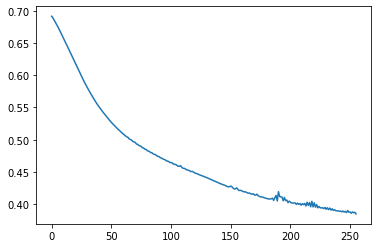

In [11]:
plt.plot(loss_epoch_arr)
plt.show()

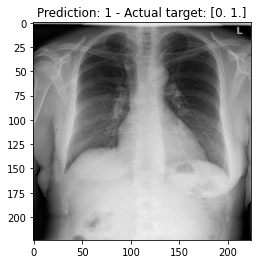

In [12]:
 with torch.no_grad():
    # Generate prediction
    prediction = net(Xt_test)

predicted_class = prediction[26].argmax()
index = 26
image = X_test[index]
true_target = y_test[index]
image = np.transpose(image, (2, 1, 0))

plt.imshow(image)
plt.title(f'Prediction: {predicted_class} - Actual target: {true_target}')
plt.show()

In [13]:
y_pred = net(Xt_train)
train_acc = torch.sum(y_pred == yt_train)
final_train_acc = train_acc/len(Xt_train)
print(final_train_acc.to("cpu").numpy() * 100)

92.42020845413208


In [14]:
y_pred = net(Xt_test)
train_acc = torch.sum(y_pred == yt_test)
final_train_acc = train_acc/len(Xt_test)
print(final_train_acc.to("cpu").numpy()*100)

90.42552709579468
